Import Libraries

In [363]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd

In [364]:
mSeed = 99
random.seed(mSeed)
torch.manual_seed(mSeed)
torch.use_deterministic_algorithms


<function torch.use_deterministic_algorithms(mode: bool, *, warn_only: bool = False) -> None>

In [365]:
import os
current_directory = os.getcwd()
main_directory = os.path.abspath(os.path.join(current_directory, "../.."))
print(main_directory)

f:\SunsetPredictor


Import Weather Data     

In [366]:
weather_data  = pd.read_csv(main_directory + "/src/weather/data/golden_co/weather_data_interpolated.csv")
wColDrop = ['Unnamed: 0.1','Unnamed: 0']
weather_data.drop(columns=wColDrop, inplace=True)
new_column_names = {'{}'.format(col): 'weather_{}'.format(col) for col in weather_data.columns}
weather_data.rename(columns=new_column_names, inplace=True)

type(weather_data['weather_date'][1])
weather_data['weather_date'][1]
weather_data

,weather_date,weather_datetime,weather_temp,weather_feelslike,weather_humidity,weather_dew,weather_precip,weather_precipprob,weather_windspeed,weather_winddir,weather_pressure,weather_visibility,weather_cloudcover,weather_conditions,weather_icon,weather_moonphase
0,2005-01-01,16:00:00,39.8,32.9,48.2,21.8,0.000,0.0,11.3,110.0,1012.9,9.9,50.0,Partially cloudy,partly-cloudy-day,0.71
1,2005-01-02,16:00:00,32.1,32.1,65.5,21.8,0.000,0.0,2.2,280.0,1017.3,9.9,100.0,Overcast,cloudy,0.74
2,2005-01-03,16:00:00,38.9,35.3,57.2,25.1,0.000,0.0,4.9,60.0,1017.6,8.7,50.0,Partially cloudy,partly-cloudy-day,0.75
3,2005-01-04,16:00:00,11.9,3.1,92.3,10.1,0.051,100.0,5.3,50.0,1017.9,1.2,100.0,"Snow, Overcast",snow,0.81
4,2005-01-05,16:00:00,5.1,-7.7,78.5,-0.1,0.000,0.0,7.8,165.0,1014.9,9.9,90.0,Partially cloudy,partly-cloudy-day,0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5839,2020-12-27,16:00:00,41.4,35.5,25.5,8.6,0.000,0.0,9.8,322.0,1015.1,9.9,62.6,Partially cloudy,partly-cloudy-day,0.42
5840,2020-12-28,16:00:00,29.2,29.2,87.9,26.1,0.000,0.0,1.3,4.0,1019.0,9.9,100.0,Overcast,cloudy,0.46
5841,2020-12-29,16:00:00,31.8,27.5,67.8,22.4,0.000,0.0,4.3,52.0,1016.0,9.9,19.3,Clear,clear-day,0.50
5842,2020-12-30,16:00:00,39.3,35.9,26.1,7.4,0.000,0.0,4.7,80.0,1017.0,9.9,19.3,Clear,clear-day,0.52


In [367]:
SunsetTimedf =pd.read_csv(main_directory +'/ImageListwTimeDif.csv')
SunsetTimedf=SunsetTimedf.drop(SunsetTimedf.columns[0],axis=1)
SunsetTimedf['Date'] = SunsetTimedf['ImDate'].str.slice(0,10)
new_column_order = ['imgCode'] + [col for col in SunsetTimedf if col != 'imgCode']
SunsetTimedf = SunsetTimedf[new_column_order]
SunsetTimedf

,imgCode,ImDate,SunTime,TimeDif,Date
0,20051030165000.raw.jpg,2005-10-30 16:50:00,2005-10-30 17:02:40,-12.666667,2005-10-30
1,20051030164000.raw.jpg,2005-10-30 16:40:00,2005-10-30 17:02:40,-22.666667,2005-10-30
2,20051030163000.raw.jpg,2005-10-30 16:30:00,2005-10-30 17:02:40,-32.666667,2005-10-30
3,20051031165000.raw.jpg,2005-10-31 16:50:00,2005-10-31 17:01:28,-11.466667,2005-10-31
4,20051031164000.raw.jpg,2005-10-31 16:40:00,2005-10-31 17:01:28,-21.466667,2005-10-31
...,...,...,...,...,...
5162,20200201170000.raw.jpg,2020-02-01 17:00:00,2020-02-01 17:21:21,-21.350000,2020-02-01
5163,20200201165000.raw.jpg,2020-02-01 16:50:00,2020-02-01 17:21:21,-31.350000,2020-02-01
5164,20200202171000.raw.jpg,2020-02-02 17:10:00,2020-02-02 17:22:32,-12.533333,2020-02-02
5165,20200202170000.raw.jpg,2020-02-02 17:00:00,2020-02-02 17:22:32,-22.533333,2020-02-02


In [368]:
merged_df = pd.merge(SunsetTimedf, weather_data, left_on = "Date", right_on="weather_date", how = "left")
merged_df=merged_df.drop(columns=['Date', 'weather_date', 'weather_datetime','weather_icon'],axis=1)
merged_df = pd.get_dummies(merged_df,columns =['weather_conditions'], dtype = int)
merged_df

,imgCode,ImDate,SunTime,TimeDif,weather_temp,weather_feelslike,weather_humidity,weather_dew,weather_precip,weather_precipprob,...,weather_cloudcover,weather_moonphase,weather_conditions_Clear,weather_conditions_Overcast,weather_conditions_Partially cloudy,"weather_conditions_Rain, Overcast","weather_conditions_Rain, Partially cloudy","weather_conditions_Snow, Fog","weather_conditions_Snow, Overcast","weather_conditions_Snow, Partially cloudy"
0,20051030165000.raw.jpg,2005-10-30 16:50:00,2005-10-30 17:02:40,-12.666667,43.7,39.4,66.5,33.3,0.007,100.0,...,90.0,0.93,0,0,0,0,1,0,0,0
1,20051030164000.raw.jpg,2005-10-30 16:40:00,2005-10-30 17:02:40,-22.666667,43.7,39.4,66.5,33.3,0.007,100.0,...,90.0,0.93,0,0,0,0,1,0,0,0
2,20051030163000.raw.jpg,2005-10-30 16:30:00,2005-10-30 17:02:40,-32.666667,43.7,39.4,66.5,33.3,0.007,100.0,...,90.0,0.93,0,0,0,0,1,0,0,0
3,20051031165000.raw.jpg,2005-10-31 16:50:00,2005-10-31 17:01:28,-11.466667,50.6,50.6,28.2,18.8,0.000,0.0,...,90.0,0.96,0,0,1,0,0,0,0,0
4,20051031164000.raw.jpg,2005-10-31 16:40:00,2005-10-31 17:01:28,-21.466667,50.6,50.6,28.2,18.8,0.000,0.0,...,90.0,0.96,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,20200201170000.raw.jpg,2020-02-01 17:00:00,2020-02-01 17:21:21,-21.350000,57.7,57.7,12.4,6.0,0.000,0.0,...,39.4,0.25,0,0,1,0,0,0,0,0
5163,20200201165000.raw.jpg,2020-02-01 16:50:00,2020-02-01 17:21:21,-31.350000,57.7,57.7,12.4,6.0,0.000,0.0,...,39.4,0.25,0,0,1,0,0,0,0,0
5164,20200202171000.raw.jpg,2020-02-02 17:10:00,2020-02-02 17:22:32,-12.533333,65.5,65.5,8.9,5.0,0.000,0.0,...,15.0,0.29,1,0,0,0,0,0,0,0
5165,20200202170000.raw.jpg,2020-02-02 17:00:00,2020-02-02 17:22:32,-22.533333,65.5,65.5,8.9,5.0,0.000,0.0,...,15.0,0.29,1,0,0,0,0,0,0,0


In [369]:
SunSetArray  = merged_df.values

In [370]:
import cv2

In [361]:
SunSetArray


array([[array([[[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               ...,

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],


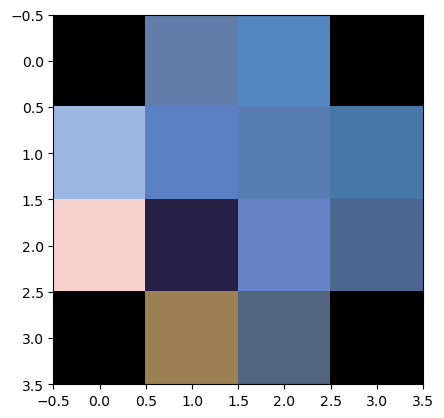

In [356]:
image = cv2.imread(main_directory+ "/Data/SunSetImg/20091204163000.raw.jpg")
image = cv2.resize(image, (4,4),interpolation = cv2.INTER_LINEAR)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [371]:
for row in SunSetArray:
    image = cv2.imread(main_directory+ "/Data/SunSetImg/" +row[0])
    # image = cv2.resize(image, (8,8),interpolation = cv2.INTER_LINEAR)
    image_array = np.array(image)
    row[0] = image_array

In [358]:
SunSetArray

array([[array([[[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               ...,

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],


In [372]:
from sklearn.model_selection import train_test_split
im_train, im_test, weather_train, weather_test = train_test_split(SunSetArray[:,0], SunSetArray[:,3:], test_size=0.2, random_state=42)

In [360]:
im_train = im_train/255

KeyboardInterrupt: 

In [469]:
np.array(im_train[1]).shape

(288, 288, 3)

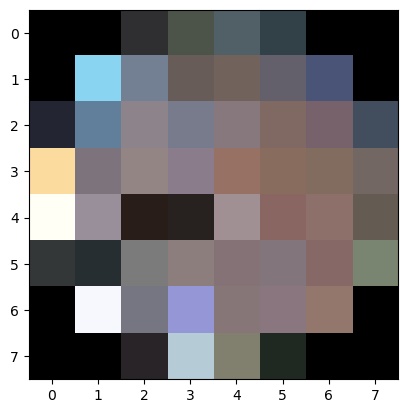

In [ ]:
plt.imshow(im_train[1])

Mini Batch 

In [374]:
weather_train[0]

array([-25.783333333333303, 40.2, 32.8, 23.7, 5.9, 0.0, 0.0, 12.8, 12.0,
       1018.9, 14.8, 35.2, 0.08, 0, 0, 1, 0, 0, 0, 0, 0], dtype=object)

In [373]:
weather_train[0].size

21

In [ ]:
np.sqrt(12288/3)

64.0

In [423]:
def sample_noise(size, device, dim=100):
    return torch.rand((size, dim), device=device)

Generator

In [480]:
class Generator(nn.Module):
    def __init__(self,latent_dim = 30, context_dim = 21):
        super(Generator,self).__init__()

        self.hidden1_latent = nn.Sequential(nn.Linear(latent_dim,30), nn.Dropout(p=.5), nn.ReLU(),)
        self.hidden1_context = nn.Sequential(nn.Linear(context_dim,30))
        self.hidden2 = nn.Sequential(nn.Linear(60,48),nn.Dropout(p=.5), nn.ReLU(), )
        
        self.hidden3 = nn.Sequential(nn.ConvTranspose2d(3,256,1,1,0), nn.Dropout(p=.5),nn.ReLU())
        self.out_layer0 = nn.Sequential(nn.Conv2d(256,3,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)

        self.hidden4 = nn.Sequential(nn.ConvTranspose2d(256,256,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden5 = nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        # First Progression output
        self.out_layer1 = nn.Sequential(nn.Conv2d(256,3,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        #------------------------------------------------------------------------------------------

        self.hidden6 = nn.Sequential(nn.ConvTranspose2d(256,256,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden7 = nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        # Second Progression output
        self.out_layer2 = nn.Sequential(nn.Conv2d(256,3,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        #------------------------------------------------------------------------------------------

        self.hidden8 = nn.Sequential(nn.ConvTranspose2d(256,256,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden9 = nn.Sequential(nn.Conv2d(256,128,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        # FirsThirdt Progression output
        self.out_layer3 = nn.Sequential(nn.Conv2d(256,3,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        #------------------------------------------------------------------------------------------

        self.hidden10 = nn.Sequential(nn.ConvTranspose2d(128,128,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden11 = nn.Sequential(nn.Conv2d(128,64,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        # Fourth Progression output
        self.out_layer4 = nn.Sequential(nn.Conv2d(128,3,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        #------------------------------------------------------------------------------------------
        self.hidden12 = nn.Sequential(nn.ConvTranspose2d(64,64,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden13 = nn.Sequential(nn.Conv2d(64,32,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        # Fithf Progression output
        self.out_layer5 = nn.Sequential(nn.Conv2d(256,3,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        #------------------------------------------------------------------------------------------
        self.hidden14 = nn.Sequential(nn.ConvTranspose2d(32,32,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden15 = nn.Sequential(nn.Conv2d(32,32,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)


        # self.hidden2 = nn.Sequential(nn.Linear(1200, 1200), nn.Dropout(p=0.5), nn.ReLU(),)
        self.out_layerFinal = nn.Sequential(nn.ConvTranspose2d(32, 3, 1, 1, 0, bias=False),nn.Tanh())

    def forward(self, noise, context, passthrough = 6):
        h = torch.cat((self.hidden1_latent(noise), self.hidden1_context(context)), dim=1)
        h = self.hidden2(h)
        print(h.shape)
        h = h.view(3,4,4)
        print(h.shape)
        h = self.hidden3(h)
        print(h.shape)
        if passthrough == 0:
            h = self.out_layer0(h)
            print("out", h.shape)
            return h
        h = self.hidden4(h)
        print(h.shape)
        h = self.hidden5(h)
        print(h.shape)
        if passthrough == 1: 
            h = self.out_layer1(h)
            print("out", h.shape)
            return h    
        h = self.hidden6(h)
        print(h.shape)
        h = self.hidden7(h)
        print(h.shape)
        if passthrough == 2: 
            h = self.out_layer2(h)
            return h
        h = self.hidden8(h)
        print(h.shape)
        h = self.hidden9(h)
        print(h.shape)
        if passthrough == 3:
            h = self.out_layer3(h)
            return h
        h = self.hidden10(h)
        print(h.shape)
        h = self.hidden11(h)
        print(h.shape)
        if passthrough == 4: 
            h = self.out_layer4(h)
            return h
        h = self.hidden12(h)
        print(h.shape)
        h = self.hidden13(h)
        print(h.shape)
        if passthrough == 5: 
            h = self.out_layer5(h)
            return h
        h = self.hidden14(h)
        print(h.shape)
        h = self.hidden15(h)
        print(h.shape)

        h = self.out_layerFinal(h)
        print(h.shape)
        return h

In [482]:
noise = sample_noise(1,device = 'cuda:0', dim = 30)
fake_weather = sample_noise(1, device = 'cuda:0', dim = 21)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Gen = Generator().to(device)
x = Gen(noise,fake_weather,0)


torch.Size([1, 48])
torch.Size([3, 4, 4])
torch.Size([256, 4, 4])
out torch.Size([3, 4, 4])


In [483]:
z = x.cpu().detach().numpy()

In [484]:
z.shape

(3, 4, 4)

In [485]:
np.transpose(z, (1, 2, 0)).shape

(4, 4, 3)

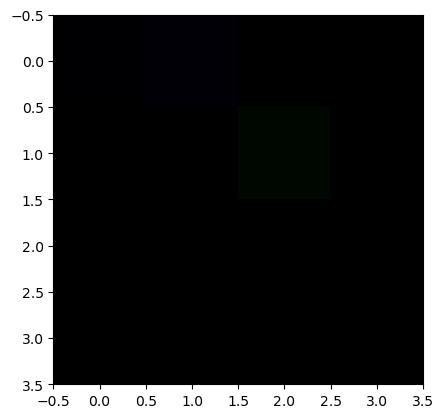

In [487]:
plt.imshow(np.transpose(z, (1, 2, 0)))

In [472]:
z

array([[[ 0.00922773, -0.0163043 , -0.00947171, ...,  0.00848682,
          0.07534461,  0.06423686],
        [ 0.02855707,  0.09320067, -0.0291713 , ...,  0.00475787,
          0.12698886,  0.06462697],
        [ 0.12271854,  0.08984101,  0.00257387, ...,  0.02393215,
          0.00676578, -0.04353028],
        ...,
        [ 0.00258307,  0.00617391,  0.13114522, ...,  0.06141292,
          0.03559648,  0.00794692],
        [ 0.04550987,  0.05066405,  0.01047644, ...,  0.04902149,
          0.10705473, -0.05107273],
        [ 0.00331222,  0.02179123, -0.04635893, ..., -0.05273753,
         -0.01694904,  0.01491664]],

       [[-0.05216452, -0.0657979 ,  0.04564738, ...,  0.0529819 ,
         -0.03720933, -0.01292201],
        [-0.0165782 ,  0.00296871, -0.0197099 , ..., -0.01202873,
          0.06220385,  0.05527291],
        [ 0.13122514, -0.01654975, -0.07245366, ...,  0.04154451,
          0.07574088, -0.03707784],
        ...,
        [-0.03998174,  0.01813627,  0.07404234, ...,  

TypeError: Invalid shape (3, 256, 256) for image data

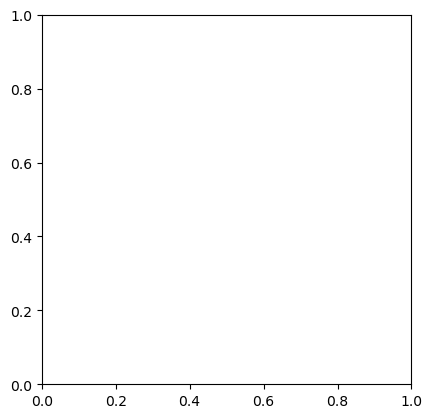

In [464]:
plt.imshow(x.cpu().detach().numpy())

In [415]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Generator().to(device)

In [416]:
summary(model, input_size=[(30,), (21,)])

torch.Size([3, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]             930
           Dropout-2                   [-1, 30]               0
              ReLU-3                   [-1, 30]               0
            Linear-4                   [-1, 30]             660
            Linear-5                   [-1, 48]           2,928
           Dropout-6                   [-1, 48]               0
              ReLU-7                   [-1, 48]               0
   ConvTranspose2d-8                 [-1, 4, 4]           1,792
           Dropout-9                 [-1, 4, 4]               0
             ReLU-10                 [-1, 4, 4]               0
  ConvTranspose2d-11                 [-1, 8, 8]       1,048,832
          Dropout-12                 [-1, 8, 8]               0
             ReLU-13                 [-1, 8, 8]               0
           Co

In [411]:
class Discriminator(nn.Module):

    def __init__(self, input_dim=256*256*3, context_dim=21):
        super(Discriminator, self).__init__()
        #Image Processing
        self.img_size = input_dim
        self.context = context_dim
        self.hidden1 = nn.Sequential(nn.Conv2d(3,32,5,1,0), nn.LeakyReLU(),)
        self.hidden2 = nn.Sequential(nn.Conv2d(32,32,3,2,0), nn.LeakyReLU(),)
        


        #Weather Processing
    def forward(self, x):
        h = self.hidden1(x)
        print(h.shape)
        h = self.hidden2(h)
        print(h.shape)
        return h

In [412]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dis = Discriminator().to(device)

In [413]:
summary(dis, input_size=(3,256,256))

torch.Size([2, 32, 252, 252])
torch.Size([2, 32, 125, 125])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 252, 252]           2,432
         LeakyReLU-2         [-1, 32, 252, 252]               0
            Conv2d-3         [-1, 32, 125, 125]           9,248
         LeakyReLU-4         [-1, 32, 125, 125]               0
Total params: 11,680
Trainable params: 11,680
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 38.64
Params size (MB): 0.04
Estimated Total Size (MB): 39.43
----------------------------------------------------------------
